# [G-4] 프로젝트: Vocabulary Size를 변경해서 시도해보기

### Import

In [5]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score #정확도 계산

## 1. 모든 단어 사용

In [6]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

### 총 데이터 수 확인

In [7]:
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


### x의 train 데이터와 test 데이터의 각 첫번째 내용 출력

In [8]:
print(x_train[0])
print(x_test[0])

[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 18292, 159, 9, 1084, 363, 13, 19231, 71, 9, 16273, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 16273, 7, 748, 48, 9, 19231, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 20, 324, 27, 56, 23406, 28185, 5, 192,

* 텍스트가 아닌 숫자로 나온 이유는 tensorflow datasets 은 미리 데이터를 전처리 시켜 텍스트를 숫자로 수치화 진행 해놓기 때문

### y의 train 데이터와 test 데이터의 각 첫번째 내용 출력

In [9]:
print(y_train[0])
print(y_test[0])

3
3


In [10]:
num_classes = max(y_train) + 1 # 0부터 시작하기 때문에 +1을 진행하여 클래스의 갯수 확인
print('클래스의 수 : {}'.format(num_classes))

클래스의 수 : 46


### 데이터 분포 확인

훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


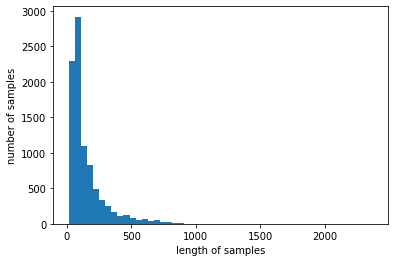

In [11]:
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

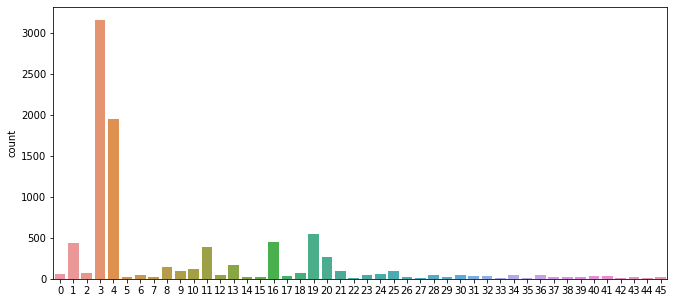

In [12]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train)
plt.show()

In [13]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 클래스 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


3번 클래스와 4번 클래스에서 가장 많은 데이터를 차지 하고 있음을 확인

### index 값을 word로 복원

#### word -> index (vocabulary read)

In [14]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

565248/550378 [==============================] - 0s 0us/step


In [15]:
word_index['the']

1

In [16]:
word_index['it']

13

#### index -> word

In [17]:
index_to_word = { index+3 : word for word, index in word_index.items() }

In [18]:
print(index_to_word[4])
print(index_to_word[16])

the
it


* index_to_word 코드를 짤 때 index 값에 +3을 더해줬기에 기존 index 에서 +3을 진행해야 원래 값으로 출력 진행  
* special토큰 pad,sos,unk 토큰으로 인해 각 단어 index 에 +3을 더해줬음

In [19]:
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
    index_to_word[index]=token

### x_trian 데이터의 0번째 index 데이터 복원

In [20]:
print(' '.join([index_to_word[index] for index in x_train[0]]))

<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


### 전체 데이터 복원

In [21]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded
print(len(x_train))

8982


In [22]:
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded
print(len(x_test))

2246


### 복원된 텍스트값 확인

In [23]:
x_train[442]

'<sos> shr profit six cts vs loss one ct net profit 80 939 vs loss 12 808 rev 7 0 mln vs 6 3 mln six months shr profit eight cts vs loss one ct net profit 101 345 vs loss 10 460 rev 13 2 mln vs 12 5 mln reuter 3'

In [24]:
x_test[442]

'<sos> tesco plc lt tsco l said lt county bank ltd had bought 165 000 shares in lt hillards plc on its behalf increasing its stake to 5 4 pct the shares were bought at 313 25p each tesco is making an opposed 151 mln stg bid for hillards hillards shares at 0900 gmt were quoted one penny firmer at 317p while tesco was one penny easier at 479p reuter 3'

### 벡터화 진행(model에 적용시킬 데이터 embedding 작업)

#### DTM 행렬

In [25]:
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 26506)


* 전체 단어 모두를 사용했기에 전체 단어에서 중복값 제거 및 필요없는 토큰 제외 26506 이라는 columns 가 생성됨을 확인

#### TF-IDF 행렬

In [26]:
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 26506)


### 나이브 베이즈 분류기

In [35]:
model = MultinomialNB()
model.fit(tfidfv, y_train)

MultinomialNB()

In [36]:
x_test_dtm = dtmvector.transform(x_test) # test 데이터 DTM 으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) # DTM -> TF-IDF 행렬로 변환

predicted = model.predict(tfidfv_test) # 테스트 데이터에 대한 예측
print("정확도:", accuracy_score(y_test, predicted)) # 실제값(y_test) 와 예측값 비교

정확도: 0.6905609973285841


In [37]:
x_test[3] # 4번째 샘플

'<sos> <unk> <unk> oil and gas partnership said it completed the sale of interests in two major oil and gas fields to lt energy assets international corp for 21 mln dlrs the company said it sold about one half of its 50 pct interest in the <unk> <unk> and north <unk> fields its two largest producing properties it said it used about 20 mln dlrs of the proceeds to <unk> principal on its senior <unk> notes semi annual principal payments on the remaining 40 mln dlrs of notes have been <unk> until december 1988 as a result it said the company said the note agreements were <unk> to reflect an <unk> of some financial <unk> and an increase of interest to 13 5 pct from 13 0 pct until december 1990 it said the <unk> exercise price for 1 125 000 warrants was also reduced to 50 cts from 1 50 dlrs the company said energy assets agreed to share the costs of increasing production at the <unk> <unk> field reuter 3'

In [38]:
y_test[3]

4

#### 시각화

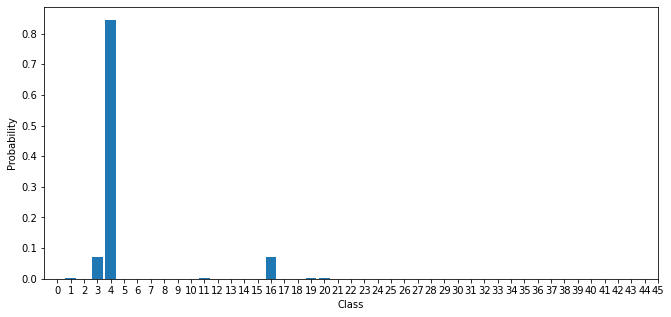

In [39]:
probability_3 = model.predict_proba(tfidfv_test[3])[0]

plt.rcParams["figure.figsize"] = (11,5)
plt.bar(model.classes_, probability_3)
plt.xlim(-1, 21)
plt.xticks(model.classes_)
plt.xlabel("Class")
plt.ylabel("Probability")
plt.show()

In [40]:
model.predict(tfidfv_test[3])

array([4])

* 모델이 4번 클래스로 예측을 했고 실제로도 4번 클래스로 정확한 예측 확인할 수 있었음

### CNB

In [41]:
cb = ComplementNB()
cb.fit(tfidfv, y_train)

ComplementNB()

In [42]:
predicted = cb.predict(tfidfv_test) # 예측
print("정확도:", accuracy_score(y_test, predicted)) # 실제값과 예측값 비교

정확도: 0.7609082813891362


### 로지스틱 회귀

In [43]:
lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
lr.fit(tfidfv, y_train)

LogisticRegression(C=10000, max_iter=3000)

In [44]:
predicted = lr.predict(tfidfv_test) # 예측
print("정확도:", accuracy_score(y_test, predicted)) # 실제값과 예측값 비교

정확도: 0.7831700801424755


### 서포트 벡터 머신

In [45]:
lsvc = LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False)
lsvc.fit(tfidfv, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1000, dual=False, max_iter=3000, penalty='l1')

In [46]:
predicted = lsvc.predict(tfidfv_test) # 예측
print("정확도:", accuracy_score(y_test, predicted)) # 실제값과 예측값 비교

정확도: 0.748886910062333


### 결정 트리

In [47]:
tree = DecisionTreeClassifier(max_depth=10, random_state=0)
tree.fit(tfidfv, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [48]:
predicted = tree.predict(tfidfv_test) # 예측
print("정확도:", accuracy_score(y_test, predicted)) # 실제값과 예측값 비교

정확도: 0.6260017809439002


### 랜덤 포레스트

In [49]:
forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(tfidfv, y_train)

RandomForestClassifier(n_estimators=5, random_state=0)

In [50]:
predicted = forest.predict(tfidfv_test) # 예측
print("정확도:", accuracy_score(y_test, predicted)) # 실제값과 예측값 비교

정확도: 0.705253784505788


### 그래디언트 부스팅 트리

In [51]:
grbt = GradientBoostingClassifier(random_state=0)
grbt.fit(tfidfv, y_train)

GradientBoostingClassifier(random_state=0)

In [52]:
predicted = grbt.predict(tfidfv_test) # 예측
print("정확도:", accuracy_score(y_test, predicted)) # 실제값과 예측값 비교

정확도: 0.7666963490650045


### 보팅

In [53]:
voting_classifier = VotingClassifier(estimators=[
         ('lr', LogisticRegression(C=10000, max_iter=3000, penalty='l2')),
        ('cb', ComplementNB()),
        ('grbt', GradientBoostingClassifier(random_state=0))
], voting='soft')
voting_classifier.fit(tfidfv, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=10000, max_iter=3000)),
                             ('cb', ComplementNB()),
                             ('grbt',
                              GradientBoostingClassifier(random_state=0))],
                 voting='soft')

In [54]:
predicted = voting_classifier.predict(tfidfv_test) # 예측
print("정확도:", accuracy_score(y_test, predicted)) # 실제값과 예측값 비교

정확도: 0.7996438112199465


### 각 모델별 정확도 성능

* 나이브 베이즈 분류기 : 정확도: 0.6905609973285841
* CNB : 정확도: 0.7609082813891362
* 로지스틱 회귀 : 정확도: 0.7831700801424755
* 서포트 벡터 머신 : 정확도: 0.748886910062333
* 결정 트리 : 정확도: 0.6260017809439002
* 랜덤 포레스트 : 정확도: 0.705253784505788
* 그래디언트 부스팅 트리 : 정확도: 0.7666963490650045
* 보팅 : 정확도: 0.7996438112199465

보팅 > 로지스틱 회귀 > 그래디언트 부스팅 트리 > CNB > 서포트 벡터 머신 > 랜덤 포레스트 > 나이브 베이즈 분류기 > 결정 트리

## 2. 빈도수 상위 5,000개의 단어만 사용

In [88]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=5000, test_split=0.2)

### 데이터 복원

In [90]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded
print(len(x_train))

8982


In [91]:
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded
print(len(x_test))

2246


### DTM 행렬 변환 및 TF-IDF 행렬로 변환 (벡터화)

In [92]:
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 4867)


In [93]:
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 4867)


### 나이브 베이즈 분류기

In [94]:
model.fit(tfidfv, y_train)

MultinomialNB()

In [95]:
x_test_dtm = dtmvector.transform(x_test)
tfidfv_test = tfidf_transformer.transform(x_test_dtm)

predicted = model.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted))

정확도: 0.6731967943009796


### CNB

In [96]:
cb.fit(tfidfv, y_train)

ComplementNB()

In [97]:
predicted = cb.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted))

정확도: 0.7707034728406055


### 로지스틱 회귀

In [98]:
lr.fit(tfidfv, y_train)

LogisticRegression(C=10000, max_iter=3000)

In [99]:
predicted = lr.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted))

정확도: 0.8036509349955476


### 서포트 벡터 머신

In [100]:
lsvc.fit(tfidfv, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1000, dual=False, max_iter=3000, penalty='l1')

In [101]:
predicted = lsvc.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted))

정확도: 0.7751558325912734


### 결정 트리

In [102]:
tree.fit(tfidfv, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [103]:
predicted = tree.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted))

정확도: 0.6179875333926982


### 랜덤 포레스트

In [104]:
forest.fit(tfidfv, y_train)

RandomForestClassifier(n_estimators=5, random_state=0)

In [105]:
predicted = forest.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted))

정확도: 0.701246660730187


### 그래디언트 부스팅 트리

In [106]:
grbt.fit(tfidfv, y_train)

GradientBoostingClassifier(random_state=0)

In [107]:
predicted = grbt.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted))

정확도: 0.767586821015138


### 보팅

In [108]:
voting_classifier.fit(tfidfv, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=10000, max_iter=3000)),
                             ('cb', ComplementNB()),
                             ('grbt',
                              GradientBoostingClassifier(random_state=0))],
                 voting='soft')

In [109]:
predicted = voting_classifier.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted))

정확도: 0.8103294746215495


### 각 모델별 정확도 성능

* 나이브 베이즈 분류기 : 정확도: 0.6731967943009796
* CNB : 정확도: 0.7707034728406055
* 로지스틱 회귀 : 정확도: 0.8036509349955476
* 서포트 벡터 머신 : 정확도: 0.7751558325912734
* 결정 트리 : 정확도: 0.6179875333926982
* 랜덤 포레스트 : 정확도: 0.701246660730187
* 그래디언트 부스팅 트리 : 정확도: 0.767586821015138
* 보팅 : 정확도: 0.8103294746215495

보팅 > 로지스틱 회귀 > 서포트 벡터 머신 > CNB > 그래디언트 부스팅 트리 > 랜덤 포레스트 > 나이브 베이즈 분류기 > 결정 트리

## 3. 직접 단어 개수를 설정해서 사용

In [29]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=2500, test_split=0.2)

### 데이터 복원

In [30]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded
print(len(x_train))

8982


In [31]:
decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded
print(len(x_test))

2246


### DTM 행렬 변환 및 TF-IDF 행렬로 변환 (벡터화)

In [32]:
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 2430)


In [33]:
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 2430)


### 나이브 베이즈 분류기

In [55]:
model.fit(tfidfv, y_train)

MultinomialNB()

In [56]:
x_test_dtm = dtmvector.transform(x_test)
tfidfv_test = tfidf_transformer.transform(x_test_dtm)

predicted = model.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted))

정확도: 0.6905609973285841


### CNB

In [57]:
cb.fit(tfidfv, y_train)

ComplementNB()

In [58]:
predicted = cb.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted))

정확도: 0.7609082813891362


### 로지스틱 회귀

In [59]:
lr.fit(tfidfv, y_train)

LogisticRegression(C=10000, max_iter=3000)

In [60]:
predicted = lr.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted))

정확도: 0.7827248441674087


### 서포트 벡터 머신

In [61]:
lsvc.fit(tfidfv, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=1000, dual=False, max_iter=3000, penalty='l1')

In [62]:
predicted = lsvc.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted))

정확도: 0.7506678539626002


### 결정 트리

In [63]:
tree.fit(tfidfv, y_train)

DecisionTreeClassifier(max_depth=10, random_state=0)

In [64]:
predicted = tree.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted))

정확도: 0.6260017809439002


### 랜덤 포레스트

In [65]:
forest.fit(tfidfv, y_train)

RandomForestClassifier(n_estimators=5, random_state=0)

In [66]:
predicted = forest.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted))

정확도: 0.705253784505788


### 그래디언트 부스팅 트리

In [67]:
grbt.fit(tfidfv, y_train)

GradientBoostingClassifier(random_state=0)

In [68]:
predicted = grbt.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted))

정확도: 0.7666963490650045


### 보팅

In [69]:
voting_classifier.fit(tfidfv, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=10000, max_iter=3000)),
                             ('cb', ComplementNB()),
                             ('grbt',
                              GradientBoostingClassifier(random_state=0))],
                 voting='soft')

In [70]:
predicted = voting_classifier.predict(tfidfv_test)
print("정확도:", accuracy_score(y_test, predicted))

정확도: 0.7996438112199465


### 각 모델별 정확도 성능

* 나이브 베이즈 분류기 : 정확도: 0.6905609973285841
* CNB : 정확도: 0.7609082813891362
* 로지스틱 회귀 : 정확도: 0.7827248441674087
* 서포트 벡터 머신 : 정확도: 0.7506678539626002
* 결정 트리 : 정확도: 0.6260017809439002
* 랜덤 포레스트 : 정확도: 0.705253784505788
* 그래디언트 부스팅 트리 : 정확도: 0.7666963490650045
* 보팅 : 정확도: 0.7996438112199465

보팅 > 로지스틱 회귀 > 그래디언트 부스팅 트리 > CNB > 서포트 벡터 머신 > 랜덤 포레스트 > 나이브 베이즈 분류기 > 결정 트리

# Reference

Going Deeper 4. 뉴스 카테고리 다중분류